# Convergence

Description of the UCI protocol: https://ucichessengine.wordpress.com/2011/03/16/description-of-uci-protocol/

Let us parse the logs first:

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
! grep "multipv 1" log2.txt  | grep -v lowerbound | grep -v upperbound > log2_g.txt

In [3]:
def parse_info(l):
    D = {}
    k = l.split()
    i = 0
    assert k[i] == "info"
    i += 1
    while i < len(k):
        if k[i] == "depth":
            D[k[i]] = int(k[i+1])
            i += 2
        elif k[i] == "seldepth":
            D[k[i]] = int(k[i+1])
            i += 2
        elif k[i] == "multipv":
            D[k[i]] = int(k[i+1])
            i += 2
        elif k[i] == "score":
            if k[i+1] == "cp":
                D["score_p"] = int(k[i+2]) / 100. # score in pawns
            i += 3
        elif k[i] == "nodes":
            D[k[i]] = int(k[i+1])
            i += 2
        elif k[i] == "nps":
            D[k[i]] = int(k[i+1])
            i += 2
        elif k[i] == "hashfull":
            D[k[i]] = int(k[i+1]) / 1000. # between 0 and 1
            i += 2
        elif k[i] == "tbhits":
            D[k[i]] = int(k[i+1])
            i += 2
        elif k[i] == "time":
            D[k[i]] = int(k[i+1]) / 1000. # elapsed time in [s]
            i += 2
        elif k[i] == "pv":
            D[k[i]] = k[i+1:]
            return D
        else:
            raise Exception("Unknown kw")

In [4]:
# Convert to an array of lists
D = []
for l in open("log2_g.txt").readlines():
    D.append(parse_info(l))

# Convert to a list of arrays
data = {}
for key in D[-1].keys():
    d = []
    for x in D:
        if key in x:
            d.append(x[key])
        else:
            d.append(-1)
    if key != "pv":
        d = array(d)
    data[key] = d

## The Speed of Search

The number of nodes searched depend linearly on time:

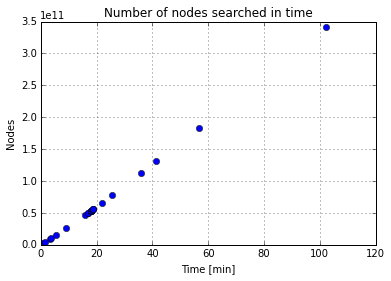

In [5]:
title("Number of nodes searched in time")
plot(data["time"] / 60., data["nodes"], "o")
xlabel("Time [min]")
ylabel("Nodes")
grid()
show()

So nodes per second is roughly constant:

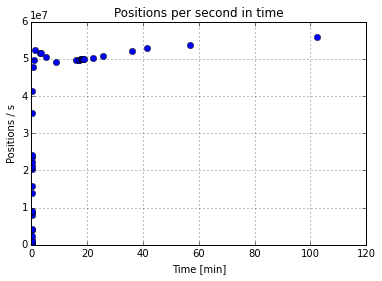

In [6]:
title("Positions per second in time")
plot(data["time"] / 60., data["nps"], "o")
xlabel("Time [min]")
ylabel("Positions / s")
grid()
show()

The hashtable usage is at full capacity:

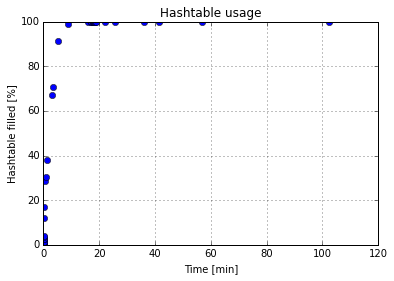

In [7]:
title("Hashtable usage")
hashfull = data["hashfull"]
hashfull[hashfull == -1] = 0
plot(data["time"] / 60., hashfull * 100, "o")
xlabel("Time [min]")
ylabel("Hashtable filled [%]")
grid()
show()

Number of nodes needed for the given depth grows exponentially, except for moves that are forced, which require very little nodes to search (those show as a horizontal plateau):

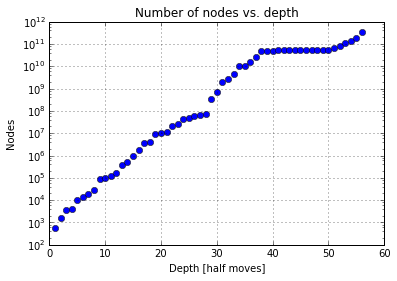

In [8]:
title("Number of nodes vs. depth")
semilogy(data["depth"], data["nodes"], "o")
xlabel("Depth [half moves]")
ylabel("Nodes")
grid()
show()

## Convergence wrt. Depth

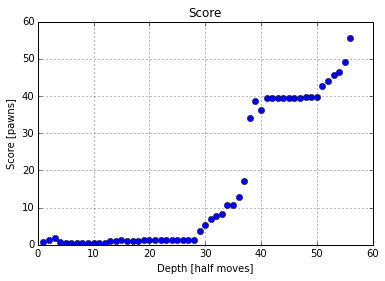

In [9]:
title("Score")
plot(data["depth"], data["score_p"], "o")
xlabel("Depth [half moves]")
ylabel("Score [pawns]")
grid()
show()

Convergence of the variations:

In [10]:
for i in range(len(data["depth"])):
    print "%2i %s" % (data["depth"][i], " ".join(data["pv"][i])[:100])

 1 d7a7
 2 d7a7 h6h5 a7a3
 3 f5f6 b5b6 d7d6 b6d6 e5d6
 4 f5f6 b5b6 d7d6 b6d6 e5d6 f8e8
 5 f5f6 b5b6 d7d6 b6d6 e5d6 f8e8 f2f3
 6 f2f4 b5b2 f5f6 b2b6 d7d6 b6d6 e5d6 f8e8
 7 f2f4 b5b2 f5f6 b2b6 d7d6 b6d6 e5d6 f8e8 f4f5
 8 d7a7 b5b2 f2f4 b2a2 f5f6 f8e8 a7e7 e8d8 e7f7 c5c4
 9 d7a7 b5b2 f2f4 b2a2 f5f6 f8e8 f4f5 a2f2 a7a3
10 d7a7 b5b2 f2f4 b2a2 f5f6 f8e8 f4f5 a2f2 a7a3 c5c4 a3c3 f2f4 h4h5
11 d7a7 b5b2 f2f4 b2a2 f5f6 f8e8 f4f5 a2e2 a7a3 c5c4 e5e6 f7e6 f5e6 e2f2 f6e5
12 d7a7 b5b2 f2f4 b2a2 f5f6 f8e8 a7a8 e8d7 f6f7 a2f2 e5e6 d7d6 a8a6 d6d5 e6e7 f2f4 f7e8 c5c4 a6a3
13 d7a7 b5b2 f2f4 b2a2 f5f6 f8g8 f4f5 c5c4 a7a8 g8h7 f6f7 a2f2 f5f6 c4c3 a8a3 c3c2 a3c3
14 d7a7 b5b2 f2f4 b2a2 f5f6 f8g8 a7a8 g8h7 f4f5 c5c4 f6f7 c4c3 e5e6 a2f2 e6e7 f2f5 f7e6 f5f2 a8h8 h7h8
15 d7a7 b5b2 f2f4 f8e8 a7a3 c5c4 a3c3 b2b4 a2a3 b4a4 f5f6 a4a6 f6g7 a6g6 g7h7 g6c6 f4f5 e8e7 a3a4 c6c5
16 d7a7 c5c4 a7a3 f8e7 f2f4 b5b4 h4h5 b4b2 f5e4 b2e2 e4d4 e2f2 a3a7 e7e8 d4c4 f2f4 c4d5 f4h4 d5d6 e8f8
17 d7a7 c5c4 a7a3 b5b2 f2f4 f8e7 f5e4 b2e2